In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [107]:
# Variables 
MIMIC_PATH = "../mimiciv2.2/hosp/"
POST_PROCESS_PATH = "./post_process/"

# make the POST_PROCESS_PATH
from pathlib import Path
Path(POST_PROCESS_PATH).mkdir(parents=True, exist_ok=True)

### READ ICD 

In [108]:
icd_all_df = pd.read_csv(MIMIC_PATH + "diagnoses_icd.csv") 

icd9_df = icd_all_df #[icd_all_df["icd_version"] == 9]
icd9_df.head()


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [109]:
# no discription field 
# icd_df.description.nunique()

In [110]:
icd9_df["icd_code"].shape

(4756326,)

## Working to Map ICD-9 Codes to the description 

The strategy used for doing this was to first separate codes which are numeric to the codes which are alpha numeric and store them to fl_df and str_df

In [111]:
code_start = []
code_end = []

for category in icd9_df["icd_code"]:    
    try:
        code_start.append(float(category))
        
    except Exception:
        code_end.append(category)
        pass

    pass
print(code_start.__len__())
print(code_end.__len__())

2251673
2504653


In [112]:
print(len(code_start) + len(code_end) == icd9_df.shape[0])

True


In [113]:
icd_str_df = icd9_df[icd9_df['icd_code'].isin(code_end)]
icd_str_df.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
7,10000032,22595853,8,V1582,9
14,10000032,22841357,7,V08,9
18,10000032,25742920,3,V462,9
23,10000032,25742920,8,V08,9
33,10000032,29079034,8,V08,9


In [114]:
icd_number_df = icd9_df[~icd9_df['icd_code'].isin(code_end)]
icd_number_df.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [115]:
icd_number_df = icd_number_df.astype({"icd_code":float})

In [116]:
# Creating a dictionary for mapping IC9-codes and their respective classification of diseases (on the codes which do not
# have any alphabets)

ICD_NUMBER_MAP = {
"Metabolic disorder" : "240-279",
"Pulmonary disease" : "460-519",
"Other forms of heart disease" : "420-429",
"Digestive disease" : "520-579",
"Ischemic heart disease" : "410-414",
"Renal insufficiency" : "580-629",
"Hypertensive disease" : "401-405",
"Symptoms, signs, & ill-defined conditions" : "780-799",
"Diseases of the blood & bloodforming organs" : "280-289", 
"Trauma" : "800-959",
"Heart failure" : "428",
"Infectious diseases" : "001-139",
"Mental disorders" : "290-319",
"Arteries & veins" : "440-459",
"Neoplasms": "140-239",
"Neurologic disease" : "320-389",
"Diseases of the musculoskeletal system & connective tissue" : "710-739",
"Other complications of procedures, NEC": "998",
"Cerebrovascular disease" : "430-438", 
"Diseases of the skin & subcutaneous tissue": "680-709",
"Complications affecting specified body systems, not elsewhere classified" : "997",
"Complications peculiar to certain specified procedures" : "996",
"Other & unspecified effects of external causes" : "990-995",
"Chronic rheumatic heart disease" :"393-398",
"Diseases of pulmonary circulation" : "415-417",
"Congenital anomalies" : "740-759",
"Complications of pregnancy, childbirth, & the puerperium" : "630-677",
"Poisoning" : "960-989",
"Complications of medical care, not elsewhere classified": "999",
"Acute Rheumatic fever": "390-392"
}

In [117]:
illness_df_from_icd = pd.DataFrame()

for category, icd_range in ICD_NUMBER_MAP.items():
    try:
        code_start, code_end = icd_range.split("-")
        # replace df_icd with df_illness
        df_icd_x_patient = icd_number_df.loc[(icd_number_df["icd_code"] >= int(code_start)) & (icd_number_df.code <= int(code_end))]
        df_icd_x_patient = df_icd_x_patient.assign(category = category)

        illness_df_from_icd = pd.concat([illness_df_from_icd, df_icd_x_patient])
    
    except Exception:
        # only have one exact code
        code_start = icd_range.split("-")[0]
        df_icd_x_patient = icd_number_df.loc[icd_number_df["icd_code"] == int(code_start)]
        df_icd_x_patient = df_icd_x_patient.assign(category = category)

        illness_df_from_icd = pd.concat([illness_df_from_icd , df_icd_x_patient])    

In [118]:
illness_df_from_icd.duplicated().sum()

0

In [119]:
icd_str_df_copy = icd_str_df.copy()
icd_str_df_copy["icd_code"] = icd_str_df["icd_code"].apply(lambda x: x.strip("EV"))
icd_str_df_copy.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
7,10000032,22595853,8,1582,9
14,10000032,22841357,7,08,9
18,10000032,25742920,3,462,9
23,10000032,25742920,8,08,9
33,10000032,29079034,8,08,9


In [120]:
# icd_str_df_copy = icd_str_df_copy.astype({"icd_code":float})
icd_str_df_copy.head()
icd_str_df_copy["icd_code"] = pd.to_numeric(icd_str_df_copy["icd_code"], errors="coerce").astype(float)



In [121]:
# Creating a dictionary for mapping IC9-codes and their respective classification of diseases (on the codes which 
# have alphabets) 


d2 = {"Supplementary classification of external causes of injury and poisoning"
: "E800-E999",
"Supp. factors influencing health" :
"V01-V86" }

# (Note) Supplementary classification of factors influencing health status and contact with health services shorten to Supp. factors
# influencing health

In [122]:
df_base_str = pd.DataFrame()

for category,icd_range in d2.items():
    
    code_start,code_end = icd_range.split("-")
     
    num1 = float(code_start.strip("EV"))
    num2 = float(code_end.strip("EV"))
    
    df_icd_x_patient = icd_str_df_copy.loc[
        (icd_str_df_copy["icd_code"].notna()) &
        (icd_str_df_copy["icd_code"].astype(float) >= num1) &
        (icd_str_df_copy["icd_code"].astype(float) <= num2)
    ]
    
    
    df_icd_x_patient = df_icd_x_patient.assign(category = category)
    
    df_base_str = pd.concat([df_base_str, df_icd_x_patient])    

In [123]:
df_base_str

,subject_id,hadm_id,seq_num,icd_code,icd_version,category
233,10000980,20897796,3,872.0,10,Supplementary classification of external cause...
458,10001401,21544441,6,890.0,10,Supplementary classification of external cause...
469,10001401,24818636,11,876.0,10,Supplementary classification of external cause...
527,10001401,27060146,15,876.0,10,Supplementary classification of external cause...
655,10001884,21192799,3,876.0,10,Supplementary classification of external cause...
...,...,...,...,...,...,...
4755884,19999043,21756272,3,39.0,10,Supp. factors influencing health
4755901,19999043,24799384,3,39.0,10,Supp. factors influencing health
4756102,19999784,21739106,2,43.0,10,Supp. factors influencing health
4756144,19999784,23664472,2,43.0,10,Supp. factors influencing health


In [124]:
illness_df_from_icd

,subject_id,hadm_id,seq_num,icd_code,icd_version,category
309144,10671739,28981554,1,460.0,9,Pulmonary disease
614702,11305776,23882079,2,460.0,9,Pulmonary disease
758171,11604900,27778665,2,460.0,9,Pulmonary disease
882470,11878774,28319306,2,460.0,9,Pulmonary disease
906076,11924401,27087609,9,460.0,9,Pulmonary disease
...,...,...,...,...,...,...
3359720,17059919,23648823,6,390.0,9,Acute Rheumatic fever
3463242,17281190,25043262,1,390.0,9,Acute Rheumatic fever
3726813,17835008,27782172,10,390.0,9,Acute Rheumatic fever
4497951,19463877,21312759,5,390.0,9,Acute Rheumatic fever


In [125]:
# This is the df, which has the mapping of ICD-9 codes

df_icd = pd.concat([illness_df_from_icd,df_base_str])

In [126]:
df_icd.reset_index(drop = True)
df_icd

,subject_id,hadm_id,seq_num,icd_code,icd_version,category
309144,10671739,28981554,1,460.0,9,Pulmonary disease
614702,11305776,23882079,2,460.0,9,Pulmonary disease
758171,11604900,27778665,2,460.0,9,Pulmonary disease
882470,11878774,28319306,2,460.0,9,Pulmonary disease
906076,11924401,27087609,9,460.0,9,Pulmonary disease
...,...,...,...,...,...,...
4755884,19999043,21756272,3,39.0,10,Supp. factors influencing health
4755901,19999043,24799384,3,39.0,10,Supp. factors influencing health
4756102,19999784,21739106,2,43.0,10,Supp. factors influencing health
4756144,19999784,23664472,2,43.0,10,Supp. factors influencing health


In [127]:
df_icd.to_csv(POST_PROCESS_PATH + "icd_mapped_categories.csv", index = False)

## Getting only sequence 1, becasue this will be the primary diagnosis.

## But first we have to merge df_icd with pat, in this way we will be able to filter out the

## first admission ID and then we will take the least number of sequence.

In [128]:
# Now working on to get only those categories which are in our selected patients.

In [129]:
patient_df = pd.read_csv(POST_PROCESS_PATH + "selected_ids.csv")

In [130]:
patient_df["subject_id"].nunique()

180733

In [131]:
patient_df

,subject_id,hadm_id,admittime,gender,anchor_age
0,10000032,22595853,2180-05-06,F,52
1,10000068,25022803,2160-03-03,F,19
2,10000084,23052089,2160-11-21,M,72
3,10000108,27250926,2163-09-27,M,25
4,10000117,22927623,2181-11-15,F,48
...,...,...,...,...,...
180728,19999733,27674281,2152-07-08,F,19
180729,19999784,26194817,2119-06-18,M,57
180730,19999828,29734428,2147-07-18,F,46
180731,19999840,26071774,2164-07-25,M,58


In [132]:
df_icd

,subject_id,hadm_id,seq_num,icd_code,icd_version,category
309144,10671739,28981554,1,460.0,9,Pulmonary disease
614702,11305776,23882079,2,460.0,9,Pulmonary disease
758171,11604900,27778665,2,460.0,9,Pulmonary disease
882470,11878774,28319306,2,460.0,9,Pulmonary disease
906076,11924401,27087609,9,460.0,9,Pulmonary disease
...,...,...,...,...,...,...
4755884,19999043,21756272,3,39.0,10,Supp. factors influencing health
4755901,19999043,24799384,3,39.0,10,Supp. factors influencing health
4756102,19999784,21739106,2,43.0,10,Supp. factors influencing health
4756144,19999784,23664472,2,43.0,10,Supp. factors influencing health


In [146]:
df_icd_x_patient = patient_df.merge(df_icd, how = "inner", on = "hadm_id")
df_icd_x_patient

,subject_id_x,hadm_id,admittime,gender,anchor_age,subject_id_y,seq_num,icd_code,icd_version,category
0,10001401,21544441,2131-06-04,F,89,10001401,6,890.0,10,Supplementary classification of external cause...
1,10001919,29897682,2124-04-20,M,59,10001919,8,39.0,10,Supp. factors influencing health
2,10002266,24160398,2131-02-28,F,31,10002266,10,39.0,10,Supp. factors influencing health
3,10002348,22725460,2112-11-30,F,77,10002348,11,39.0,10,Supp. factors influencing health
4,10002528,23193578,2168-12-11,F,26,10002528,7,869.0,10,Supplementary classification of external cause...
...,...,...,...,...,...,...,...,...,...,...
29262,19997540,29178502,2154-03-03,M,30,19997540,2,915.0,9,Supplementary classification of external cause...
29263,19997843,20277361,2120-11-17,M,47,19997843,6,872.0,10,Supplementary classification of external cause...
29264,19997843,20277361,2120-11-17,M,47,19997843,16,876.0,10,Supplementary classification of external cause...
29265,19997886,20793010,2186-11-12,M,67,19997886,2,43.0,10,Supp. factors influencing health


In [134]:
df_icd_x_patient["hadm_id"].nunique()

21359

In [135]:
# The reason why there are not 3923 rows in df is that a patient on his admission may be diagnosed by multiple disorders
# i.e categories. But if we check unique hadm_ids, they are 3923. which means that the data is retrieved for 3923 patients,
# but since one patient can have multiple diseases, so the total rows become 38310.

## Working to filter out the min of sequence so that we will get the primary diagnosis.

In [136]:
df2 = df_icd_x_patient.sort_values(["subject_id_x", "seq_num"]).drop_duplicates('subject_id_y')
df2

,subject_id_x,hadm_id,admittime,gender,anchor_age,subject_id_y,seq_num,icd_code,icd_version,category
0,10001401,21544441,2131-06-04,F,89,10001401,6,890.0,10,Supplementary classification of external cause...
1,10001919,29897682,2124-04-20,M,59,10001919,8,39.0,10,Supp. factors influencing health
2,10002266,24160398,2131-02-28,F,31,10002266,10,39.0,10,Supp. factors influencing health
3,10002348,22725460,2112-11-30,F,77,10002348,11,39.0,10,Supp. factors influencing health
4,10002528,23193578,2168-12-11,F,26,10002528,7,869.0,10,Supplementary classification of external cause...
...,...,...,...,...,...,...,...,...,...,...
29261,19997538,22701415,2168-05-01,M,53,19997538,7,871.0,10,Supplementary classification of external cause...
29262,19997540,29178502,2154-03-03,M,30,19997540,2,915.0,9,Supplementary classification of external cause...
29263,19997843,20277361,2120-11-17,M,47,19997843,6,872.0,10,Supplementary classification of external cause...
29265,19997886,20793010,2186-11-12,M,67,19997886,2,43.0,10,Supp. factors influencing health


In [137]:
df2.to_csv(POST_PROCESS_PATH + "patients_first_diagnosis_cat.csv", index = False)

In [138]:
df2['subject_id_x'].duplicated().sum()

0

In [139]:
code_start = df2.groupby("category").size().sort_values(ascending= False).head(10)

In [140]:
code_end = df2.groupby("category").size().sort_values(ascending= False).to_frame()

In [141]:
code_end= code_end.reset_index().rename(columns = {0:"Count"})

In [142]:
code_end['percentage'] = code_end.Count.apply(lambda x: x*100/code_end.Count.sum())
c= code_end.head(10)
c

,category,Count,percentage
0,Supplementary classification of external cause...,11946,55.929585
1,Supp. factors influencing health,8757,40.999110
2,Cerebrovascular disease,566,2.649937
3,Diseases of pulmonary circulation,49,0.229411
4,Other & unspecified effects of external causes,11,0.051501
5,Acute Rheumatic fever,10,0.046819
6,Pulmonary disease,8,0.037455
7,"Complications of pregnancy, childbirth, & the ...",3,0.014046
8,"Symptoms, signs, & ill-defined conditions",3,0.014046
9,Trauma,3,0.014046


# Viz for Top 10 Disease Dignosis

/tmp/ipykernel_3486766/1289272358.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = c, x = 'percentage', y = 'category', palette='PuBuGn_r')


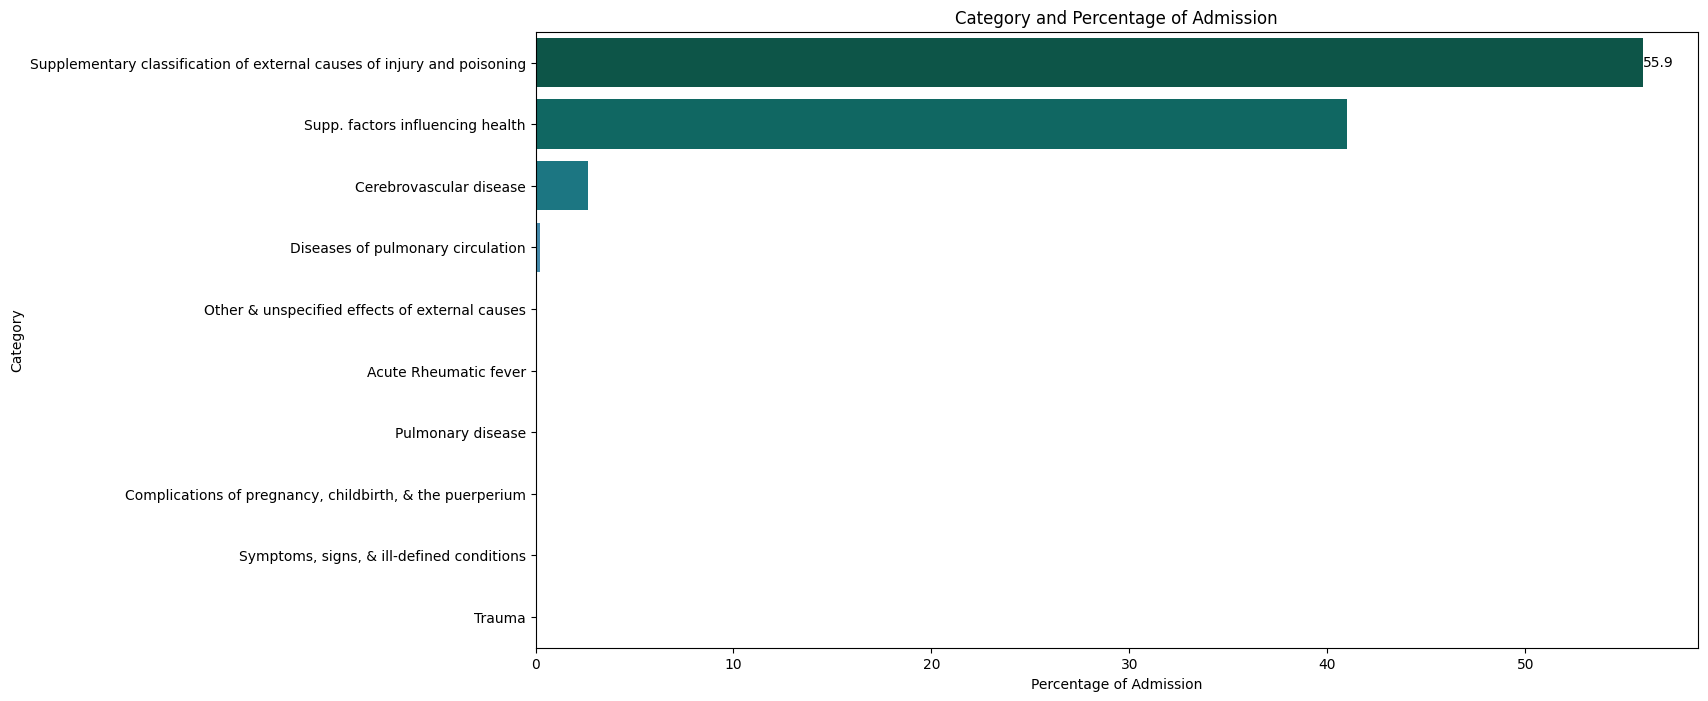

In [143]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.barplot(data = c, x = 'percentage', y = 'category', palette='PuBuGn_r')

ax.bar_label(ax.containers[0], fmt = '%.1f')

plt.xlabel(x:="Percentage of Admission")
plt.ylabel(y:="Category")
plt.title(t:= y + " and " + x)

plt.xticks(rotation=0)
plt.savefig(f"EDA_{t}.jpeg", bbox_inches = "tight")
plt.show()

In [151]:
all_category = df2.groupby("category")['gender'].value_counts().to_frame()
all_category

count
category                                           gender       
Acute Rheumatic fever                              F           7
                                                   M           3
Cerebrovascular disease                            F         322
                                                   M         244
Chronic rheumatic heart disease                    M           1
                                                   F           1
Complications of pregnancy, childbirth, & the p... F           3
Digestive disease                                  F           1
Diseases of pulmonary circulation                  M          31
                                                   F          18
Other & unspecified effects of external causes     F           6
                                                   M           5
Pulmonary disease                                  F           4
                                                   M           4
Supp. factors influencing health                   F        5164
                                                   M        3593
Supplementary classification of external causes... M        6109
                                                   F        5837
Symptoms, signs, & ill-defined conditions          M           3
Trauma                                             M           3

In [155]:
all_category.rename(columns = {"gender":"Count"}, inplace = True)
all_category

count
category                                           gender       
Acute Rheumatic fever                              F           7
                                                   M           3
Cerebrovascular disease                            F         322
                                                   M         244
Chronic rheumatic heart disease                    M           1
                                                   F           1
Complications of pregnancy, childbirth, & the p... F           3
Digestive disease                                  F           1
Diseases of pulmonary circulation                  M          31
                                                   F          18
Other & unspecified effects of external causes     F           6
                                                   M           5
Pulmonary disease                                  F           4
                                                   M           4
Supp. factors influencing health                   F        5164
                                                   M        3593
Supplementary classification of external causes... M        6109
                                                   F        5837
Symptoms, signs, & ill-defined conditions          M           3
Trauma                                             M           3

In [157]:
sorted_cat = all_category.reset_index().sort_values(['gender', 'count'])
sorted_cat.rename(columns = {"gender":"Gender"}, inplace = True)
sorted_cat

,category,Gender,count
5,Chronic rheumatic heart disease,F,1
7,Digestive disease,F,1
6,"Complications of pregnancy, childbirth, & the ...",F,3
12,Pulmonary disease,F,4
10,Other & unspecified effects of external causes,F,6
0,Acute Rheumatic fever,F,7
9,Diseases of pulmonary circulation,F,18
2,Cerebrovascular disease,F,322
14,Supp. factors influencing health,F,5164
17,Supplementary classification of external cause...,F,5837


In [158]:
# sns.barplot(data = sorted_cat, x='category' ,y = 'Count', hue= 'sex')

In [161]:
top_10 = df2.groupby("category").size().sort_values(ascending= False).head(10).index
top_10

Index(['Supplementary classification of external causes of injury and poisoning',
       'Supp. factors influencing health', 'Cerebrovascular disease',
       'Diseases of pulmonary circulation',
       'Other & unspecified effects of external causes',
       'Acute Rheumatic fever', 'Pulmonary disease',
       'Complications of pregnancy, childbirth, & the puerperium',
       'Symptoms, signs, & ill-defined conditions', 'Trauma'],
      dtype='object', name='category')

In [162]:
top_10_cat = df2.groupby("category").size().sort_values(ascending= False).head(10)
top_10_cat

category
Supplementary classification of external causes of injury and poisoning    11946
Supp. factors influencing health                                            8757
Cerebrovascular disease                                                      566
Diseases of pulmonary circulation                                             49
Other & unspecified effects of external causes                                11
Acute Rheumatic fever                                                         10
Pulmonary disease                                                              8
Complications of pregnancy, childbirth, & the puerperium                       3
Symptoms, signs, & ill-defined conditions                                      3
Trauma                                                                         3
dtype: int64

In [163]:
top_10_m_f = all_category.loc[top_10]
top_10_m_f = top_10_m_f.reset_index()
top_10_m_f

,category,gender,count
0,Supplementary classification of external cause...,M,6109
1,Supplementary classification of external cause...,F,5837
2,Supp. factors influencing health,F,5164
3,Supp. factors influencing health,M,3593
4,Cerebrovascular disease,F,322
5,Cerebrovascular disease,M,244
6,Diseases of pulmonary circulation,M,31
7,Diseases of pulmonary circulation,F,18
8,Other & unspecified effects of external causes,F,6
9,Other & unspecified effects of external causes,M,5


In [165]:
top_10_m_f = top_10_m_f.assign(percentage = lambda x: top_10_m_f["count"]/top_10_m_f["count"].sum()*100)
top_10_m_f

,category,gender,count,percentage
0,Supplementary classification of external cause...,M,6109,28.605544
1,Supplementary classification of external cause...,F,5837,27.331897
2,Supp. factors influencing health,F,5164,24.180558
3,Supp. factors influencing health,M,3593,16.824312
4,Cerebrovascular disease,F,322,1.507773
5,Cerebrovascular disease,M,244,1.142536
6,Diseases of pulmonary circulation,M,31,0.145158
7,Diseases of pulmonary circulation,F,18,0.084285
8,Other & unspecified effects of external causes,F,6,0.028095
9,Other & unspecified effects of external causes,M,5,0.023413


# Visualization for Male and Female proportion for the top 10 diseases dignosis

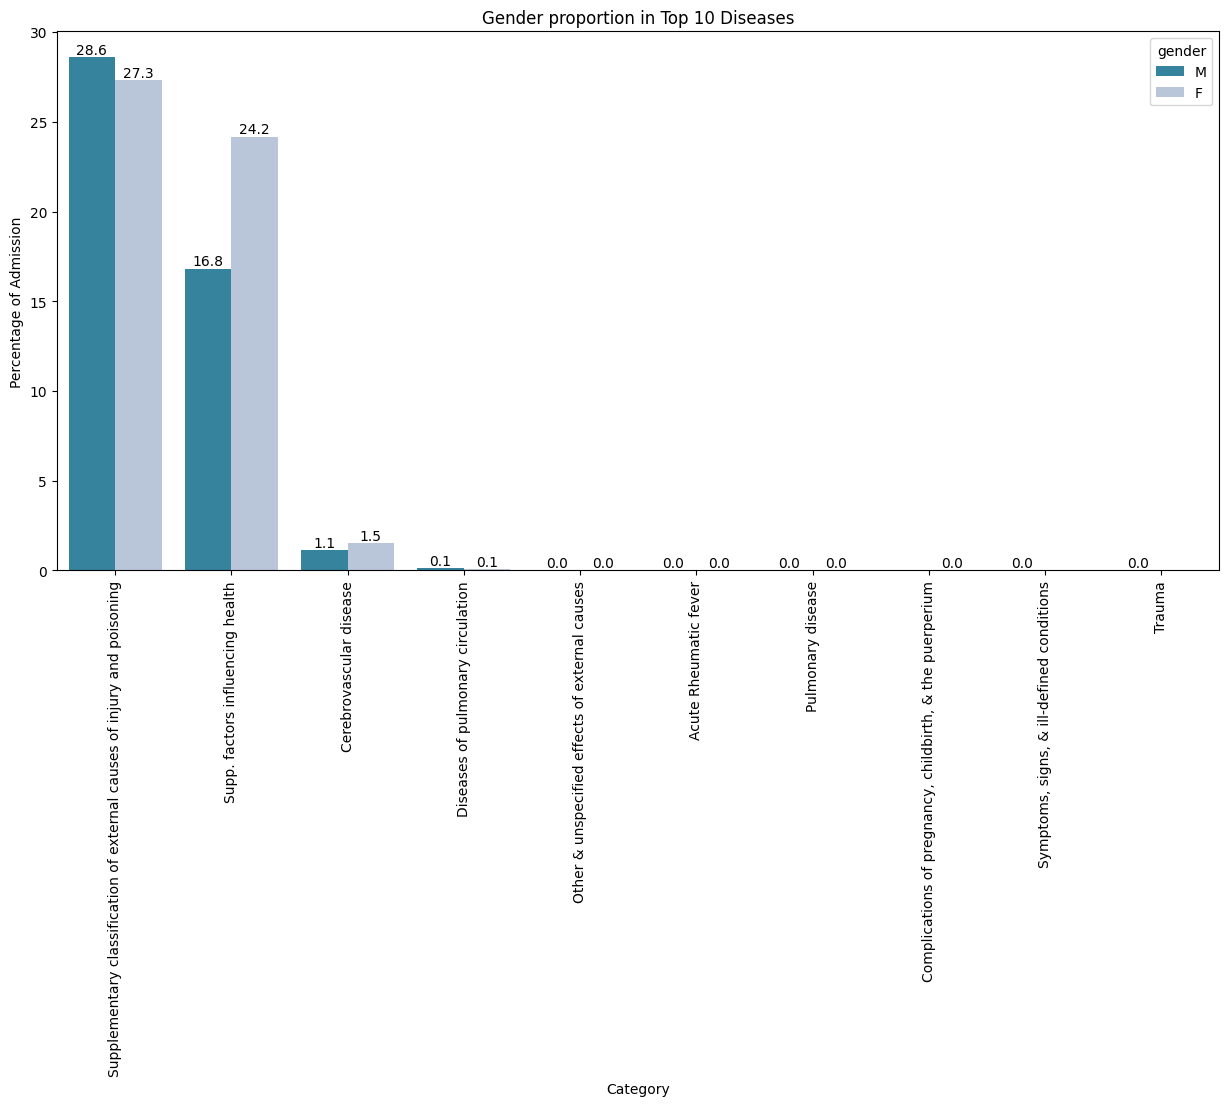

In [166]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.barplot(data = top_10_m_f, x='category' ,y = 'percentage', hue= 'gender',palette='PuBuGn_r')

for category in ax.containers:
    ax.bar_label(category , fmt = '%.1f')

plt.xlabel(x:="Category")
plt.ylabel(y:="Percentage of Admission")
plt.title(t:= "Gender proportion in Top 10 Diseases")

plt.xticks(rotation=90)
plt.savefig(POST_PROCESS_PATH + f"EDA_{t}.jpeg", bbox_inches = "tight")
plt.show()

# Working to Vizualize

### Diagnosis 
- Ethnicity
- Seasons
- Marital Status
- Emergency Type

In [168]:
demDetail = pd.read_csv(MIMIC_PATH + "admissions.csv")

In [169]:
demDetail.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag'],
      dtype='object')

In [170]:
df2.columns, df2.shape

(Index(['subject_id_x', 'hadm_id', 'admittime', 'gender', 'anchor_age',
        'subject_id_y', 'seq_num', 'icd_code', 'icd_version', 'category'],
       dtype='object'),
 (21359, 10))

In [171]:
df33 = df2.merge(demDetail, left_on = ["subject_id_x", "hadm_id"], right_on= ["subject_id", "hadm_id"], how="left")
df33

,subject_id_x,hadm_id,admittime_x,gender,anchor_age,subject_id_y,seq_num,icd_code,icd_version,category,...,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10001401,21544441,2131-06-04,F,89,10001401,6,890.0,10,Supplementary classification of external cause...,...,P872K3,PHYSICIAN REFERRAL,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,WHITE,NaN,NaN,0
1,10001919,29897682,2124-04-20,M,59,10001919,8,39.0,10,Supp. factors influencing health,...,P29BE6,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,OTHER,NaN,NaN,0
2,10002266,24160398,2131-02-28,F,31,10002266,10,39.0,10,Supp. factors influencing health,...,P92SZV,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0
3,10002348,22725460,2112-11-30,F,77,10002348,11,39.0,10,Supp. factors influencing health,...,P35WT5,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,WHITE,2112-11-30 15:08:00,2112-11-30 23:24:00,0
4,10002528,23193578,2168-12-11,F,26,10002528,7,869.0,10,Supplementary classification of external cause...,...,P42ZKF,TRANSFER FROM HOSPITAL,REHAB,Other,ENGLISH,SINGLE,WHITE,2168-12-11 00:20:00,2168-12-11 06:18:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21354,19997538,22701415,2168-05-01,M,53,19997538,7,871.0,10,Supplementary classification of external cause...,...,P68URZ,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0
21355,19997540,29178502,2154-03-03,M,30,19997540,2,915.0,9,Supplementary classification of external cause...,...,P503ZI,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2154-03-02 23:02:00,2154-03-03 02:45:00,0
21356,19997843,20277361,2120-11-17,M,47,19997843,6,872.0,10,Supplementary classification of external cause...,...,P39UDS,CLINIC REFERRAL,SKILLED NURSING FACILITY,Other,?,NaN,UNKNOWN,2120-11-17 21:25:00,2120-11-18 02:39:00,0
21357,19997886,20793010,2186-11-12,M,67,19997886,2,43.0,10,Supp. factors influencing health,...,P86FCY,CLINIC REFERRAL,HOSPICE,Other,ENGLISH,WIDOWED,WHITE,2186-11-11 16:45:00,2186-11-12 08:27:00,0


In [172]:
df33.to_csv(POST_PROCESS_PATH + "patients_with_cat_and_diseases.csv", index = False)

In [173]:
df33.columns

Index(['subject_id_x', 'hadm_id', 'admittime_x', 'gender', 'anchor_age',
       'subject_id_y', 'seq_num', 'icd_code', 'icd_version', 'category',
       'subject_id', 'admittime_y', 'dischtime', 'deathtime', 'admission_type',
       'admit_provider_id', 'admission_location', 'discharge_location',
       'insurance', 'language', 'marital_status', 'race', 'edregtime',
       'edouttime', 'hospital_expire_flag'],
      dtype='object')

In [176]:
all_ms = df33.groupby("category")['marital_status'].value_counts().to_frame()

all_ms.rename(columns = {"marital_status":"count"}, inplace = True)

sorted_ms = all_ms.reset_index().sort_values(['marital_status', 'count'])

In [179]:
top_10 = df33.groupby("category").size().sort_values(ascending= False).head(10).index

top_10_cat = df33.groupby("category").size().sort_values(ascending= False).head(10)
# top_10_cat

top_10_ms = all_ms.loc[top_10]

top_10_ms = top_10_ms.assign(percentage = lambda x: top_10_ms["count"]/top_10_ms["count"].sum()*100)
top_10_ms = top_10_ms.reset_index() 

In [180]:
top_10_ms

,category,marital_status,count,percentage
0,Supplementary classification of external cause...,MARRIED,4700,24.095150
1,Supplementary classification of external cause...,SINGLE,3971,20.357839
2,Supplementary classification of external cause...,WIDOWED,1217,6.239106
3,Supplementary classification of external cause...,DIVORCED,836,4.285861
4,Supp. factors influencing health,MARRIED,3528,18.086743
5,Supp. factors influencing health,SINGLE,3051,15.641341
6,Supp. factors influencing health,WIDOWED,974,4.993335
7,Supp. factors influencing health,DIVORCED,668,3.424587
8,Cerebrovascular disease,MARRIED,266,1.363683
9,Cerebrovascular disease,SINGLE,135,0.692095


# Visual that represents Percentages of Marital status against top 10 disease categories.

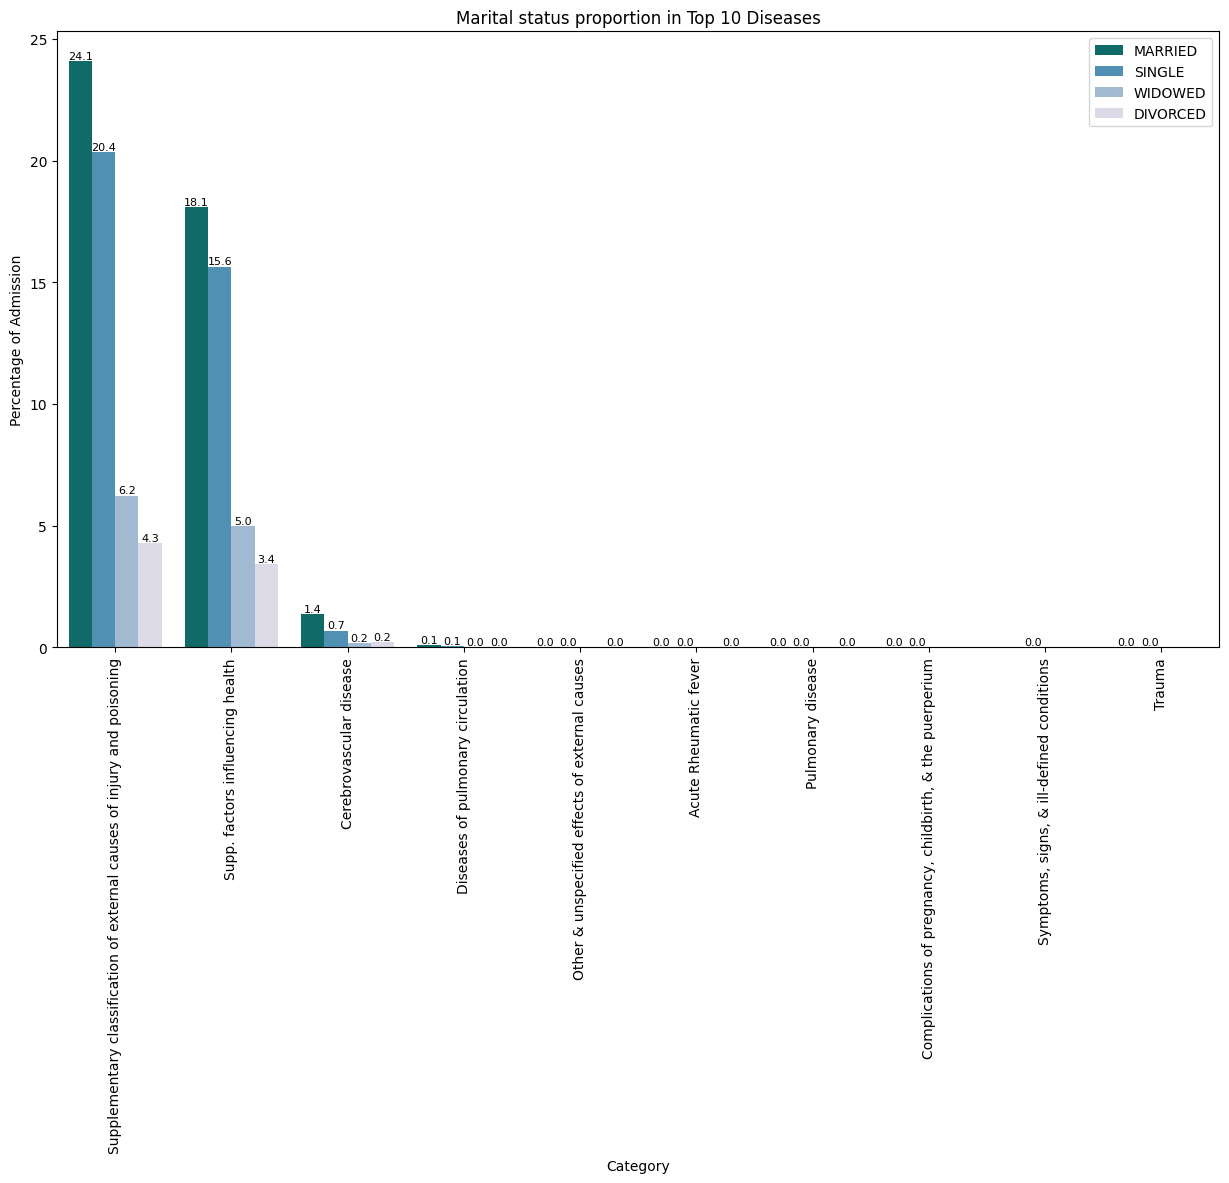

In [181]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.barplot(data = top_10_ms, x='category' ,y = 'percentage', hue= 'marital_status', palette='PuBuGn_r')

for category in ax.containers:
    ax.bar_label(category , fmt = '%.1f', fontsize=8)

plt.xlabel(x:="Category")
plt.ylabel(y:="Percentage of Admission")
plt.title(t:= "Marital status proportion in Top 10 Diseases")
plt.legend(loc = "upper right")
plt.xticks(rotation=90)
plt.savefig(POST_PROCESS_PATH + f"EDA_{t}.jpeg", bbox_inches = "tight")
plt.show()

In [183]:
all_at = df33.groupby("category")['admission_type'].value_counts().to_frame() #at = admission type

all_at.rename(columns = {"admission_type":"count"}, inplace = True)

sorted_at = all_at.reset_index().sort_values(['admission_type', 'count'])

# sns.barplot(data = sorted_at, x='category' ,y = 'Count', hue= 'admission_type_descr')

top_10 = df33.groupby("category").size().sort_values(ascending= False).head(10).index

top_10_cat = df33.groupby("category").size().sort_values(ascending= False).head(10)
# top_10_cat

top_10_at = all_at.loc[top_10]
# top_10_ms

top_10_at = top_10_at.assign(percentage = lambda x: top_10_at["count"]/top_10_at["count"].sum()*100)
top_10_at = top_10_at.reset_index() 


In [184]:
top_10_at

,category,admission_type,count,percentage
0,Supplementary classification of external cause...,EW EMER.,4136,19.366923
1,Supplementary classification of external cause...,OBSERVATION ADMIT,3435,16.084473
2,Supplementary classification of external cause...,URGENT,1721,8.058625
3,Supplementary classification of external cause...,EU OBSERVATION,1078,5.047762
4,Supplementary classification of external cause...,SURGICAL SAME DAY ADMISSION,974,4.560779
5,Supplementary classification of external cause...,DIRECT EMER.,271,1.268964
6,Supplementary classification of external cause...,DIRECT OBSERVATION,158,0.739839
7,Supplementary classification of external cause...,ELECTIVE,134,0.627458
8,Supplementary classification of external cause...,AMBULATORY OBSERVATION,39,0.182618
9,Supp. factors influencing health,EW EMER.,2370,11.097584


# Visual that represents Percentages of Admission Type against top 10 disease categories

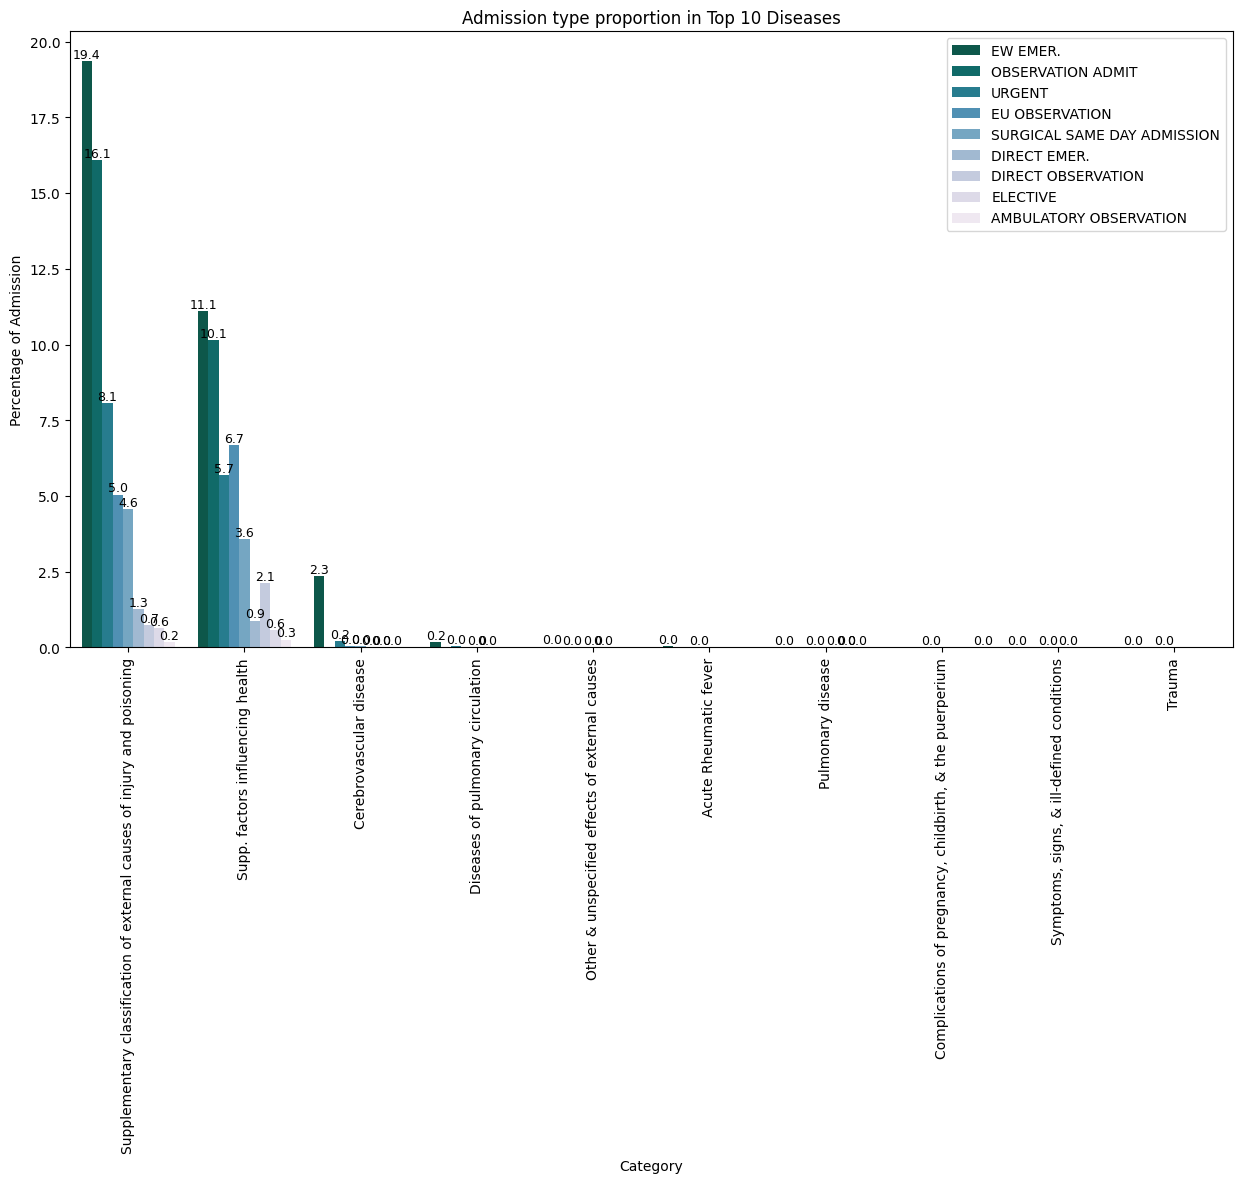

In [185]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.barplot(data = top_10_at, x='category' ,y = 'percentage', hue= 'admission_type',palette='PuBuGn_r')

for category in ax.containers:
    ax.bar_label(category , fmt = '%.1f', fontsize=9)

plt.xlabel(x:="Category")
plt.ylabel(y:="Percentage of Admission")
plt.title(t:= "Admission type proportion in Top 10 Diseases")
plt.legend(loc = "upper right")
plt.xticks(rotation=90)
plt.savefig(POST_PROCESS_PATH + f"EDA_{t}.jpeg", bbox_inches = "tight")
plt.show()

In [191]:
df33 = pd.read_csv(POST_PROCESS_PATH + "patients_with_cat_and_diseases.csv")
df33

,subject_id_x,hadm_id,admittime_x,gender,anchor_age,subject_id_y,seq_num,icd_code,icd_version,category,...,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10001401,21544441,2131-06-04,F,89,10001401,6,890.0,10,Supplementary classification of external cause...,...,P872K3,PHYSICIAN REFERRAL,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,WHITE,NaN,NaN,0
1,10001919,29897682,2124-04-20,M,59,10001919,8,39.0,10,Supp. factors influencing health,...,P29BE6,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,OTHER,NaN,NaN,0
2,10002266,24160398,2131-02-28,F,31,10002266,10,39.0,10,Supp. factors influencing health,...,P92SZV,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0
3,10002348,22725460,2112-11-30,F,77,10002348,11,39.0,10,Supp. factors influencing health,...,P35WT5,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,WHITE,2112-11-30 15:08:00,2112-11-30 23:24:00,0
4,10002528,23193578,2168-12-11,F,26,10002528,7,869.0,10,Supplementary classification of external cause...,...,P42ZKF,TRANSFER FROM HOSPITAL,REHAB,Other,ENGLISH,SINGLE,WHITE,2168-12-11 00:20:00,2168-12-11 06:18:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21354,19997538,22701415,2168-05-01,M,53,19997538,7,871.0,10,Supplementary classification of external cause...,...,P68URZ,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0
21355,19997540,29178502,2154-03-03,M,30,19997540,2,915.0,9,Supplementary classification of external cause...,...,P503ZI,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2154-03-02 23:02:00,2154-03-03 02:45:00,0
21356,19997843,20277361,2120-11-17,M,47,19997843,6,872.0,10,Supplementary classification of external cause...,...,P39UDS,CLINIC REFERRAL,SKILLED NURSING FACILITY,Other,?,NaN,UNKNOWN,2120-11-17 21:25:00,2120-11-18 02:39:00,0
21357,19997886,20793010,2186-11-12,M,67,19997886,2,43.0,10,Supp. factors influencing health,...,P86FCY,CLINIC REFERRAL,HOSPICE,Other,ENGLISH,WIDOWED,WHITE,2186-11-11 16:45:00,2186-11-12 08:27:00,0


## Extracting Seasons from Admission Date

### mapping months to seasons 
1. Jan  1 Winter
1. Feb  2 Winter
1. Mar  3 Spring
1. Apr  4 Spring
1. May  5 Spring
1. Jun  6 Summer
1. Jul  7 Summer
1. Aug  8 Summer
1. Sep  9 Autumn
1. Oct  10 Autumn
1. Nov  11 Autumn
1. Dec  12 Winter 

In [188]:
winter = [12,1,2]
spring = [3,4,5]
summer = [6,7,8]
autumn = [9,10,11]

In [189]:
def seasons(date):
    
    month = int(np.datetime64(date).astype('object').month)
    
    if month in [12,1,2]:
        return "winter"
        
    elif month in [3,4,5]:
        return "spring"
    
    elif month in [6,7,8]:
        return "summer"
    
    elif month in [9,10,11]:
        return "autumn"

In [193]:
df33['seasons'] = df33["admittime_x"].apply(seasons)

In [194]:
all_s = df33.groupby("category")['seasons'].value_counts().to_frame() #s = seasons

all_s.rename(columns = {"seasons":"count"}, inplace = True)

sorted_s = all_s.reset_index().sort_values(['seasons', 'count'])

top_10 = df33.groupby("category").size().sort_values(ascending= False).head(10).index

top_10_cat = df33.groupby("category").size().sort_values(ascending= False).head(10)

top_10_s = all_s.loc[top_10]

top_10_s = top_10_s.assign(percentage = lambda x: top_10_s["count"]/top_10_s["count"].sum()*100)
top_10_s = top_10_s.reset_index() 


In [195]:
top_10_s

,category,seasons,count,percentage
0,Supplementary classification of external cause...,autumn,3025,14.164638
1,Supplementary classification of external cause...,summer,3007,14.080352
2,Supplementary classification of external cause...,spring,2998,14.038209
3,Supplementary classification of external cause...,winter,2916,13.654242
4,Supp. factors influencing health,spring,2245,10.512268
5,Supp. factors influencing health,summer,2236,10.470125
6,Supp. factors influencing health,winter,2146,10.048698
7,Supp. factors influencing health,autumn,2130,9.973778
8,Cerebrovascular disease,autumn,162,0.758569
9,Cerebrovascular disease,spring,137,0.641506


# Visual that represents Percentages of Seasons against top 10 disease categories

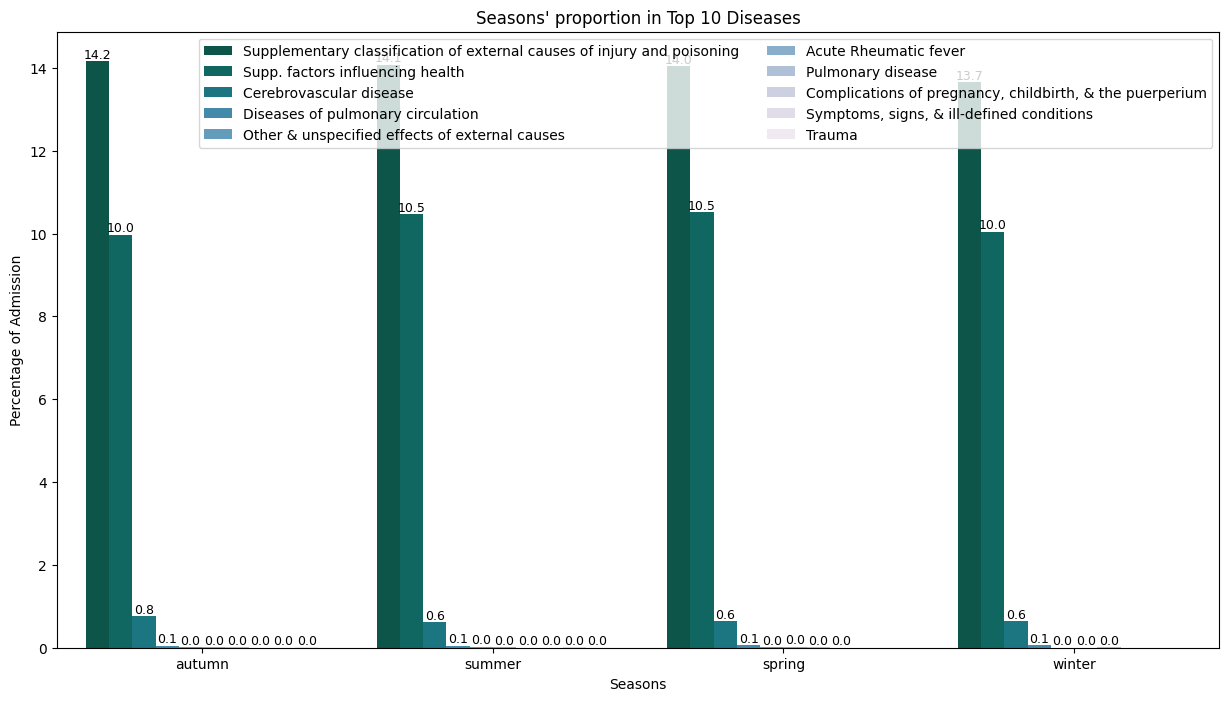

In [197]:
fig, ax = plt.subplots(figsize=(15, 8))

ax = sns.barplot(data = top_10_s, x='seasons' ,y = 'percentage', hue= 'category',palette='PuBuGn_r')

for category in ax.containers:
    ax.bar_label(category , fmt = '%.1f', fontsize=9)

plt.xlabel(x:="Seasons")
plt.ylabel(y:="Percentage of Admission")
plt.title(t:= "Seasons' proportion in Top 10 Diseases")


h,l = ax.axes.get_legend_handles_labels()
ax.axes.legend_.remove()
ax.legend(h,l, ncol=2) 


plt.xticks(rotation=0)
plt.savefig(POST_PROCESS_PATH + f"EDA_{t}.jpeg", bbox_inches = "tight")
plt.show()

In [198]:
df33.columns

Index(['subject_id_x', 'hadm_id', 'admittime_x', 'gender', 'anchor_age',
       'subject_id_y', 'seq_num', 'icd_code', 'icd_version', 'category',
       'subject_id', 'admittime_y', 'dischtime', 'deathtime', 'admission_type',
       'admit_provider_id', 'admission_location', 'discharge_location',
       'insurance', 'language', 'marital_status', 'race', 'edregtime',
       'edouttime', 'hospital_expire_flag', 'seasons'],
      dtype='object')

In [222]:
all_e = df33.groupby("category")['race'].value_counts().to_frame()#e = ethnicity
top_10 = df33.groupby("category").size().sort_values(ascending= False).head(10).index
# in row the count 
all_e = all_e.reset_index().sort_values(["category", "count"])
all_e

,category,race,count
2,Acute Rheumatic fever,ASIAN - ASIAN INDIAN,1
1,Acute Rheumatic fever,BLACK/AFRICAN AMERICAN,2
0,Acute Rheumatic fever,WHITE,7
20,Cerebrovascular disease,ASIAN - ASIAN INDIAN,1
21,Cerebrovascular disease,ASIAN - SOUTH EAST ASIAN,1
...,...,...,...
125,"Symptoms, signs, & ill-defined conditions",HISPANIC OR LATINO,1
124,"Symptoms, signs, & ill-defined conditions",WHITE,2
126,Trauma,ASIAN,1
127,Trauma,OTHER,1


# Visual that represents Percentages of Ethnicities against top 10 disease categories

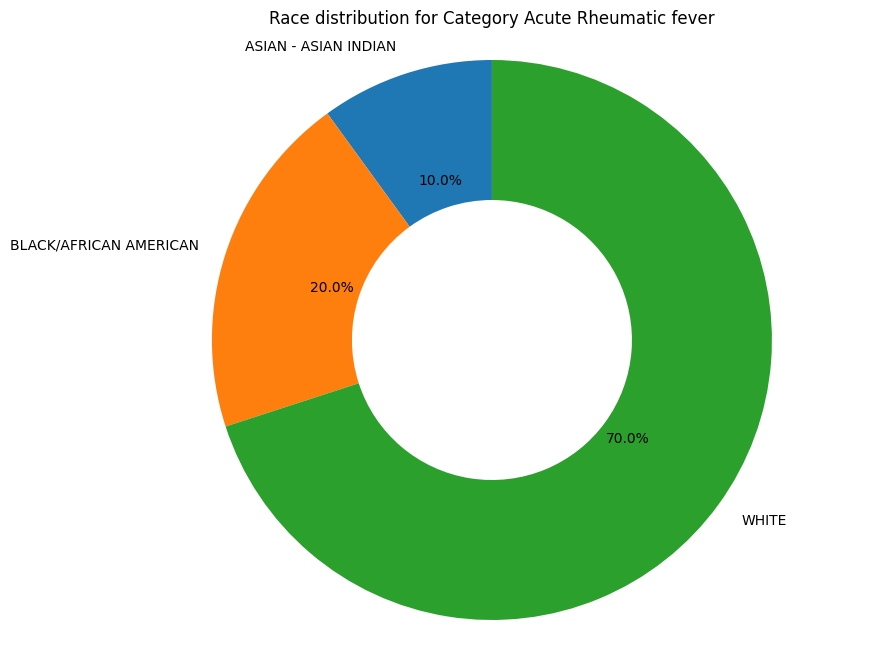

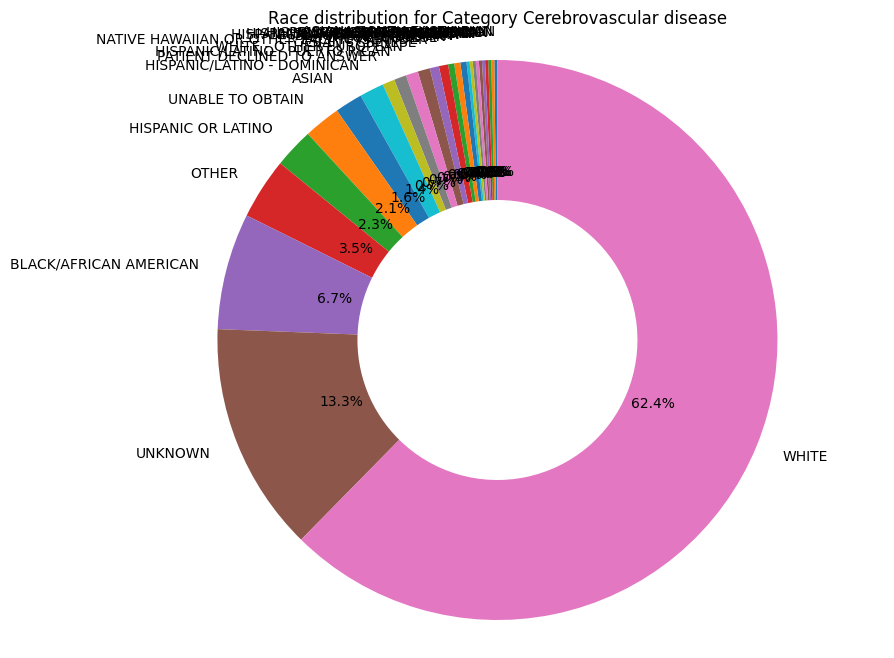

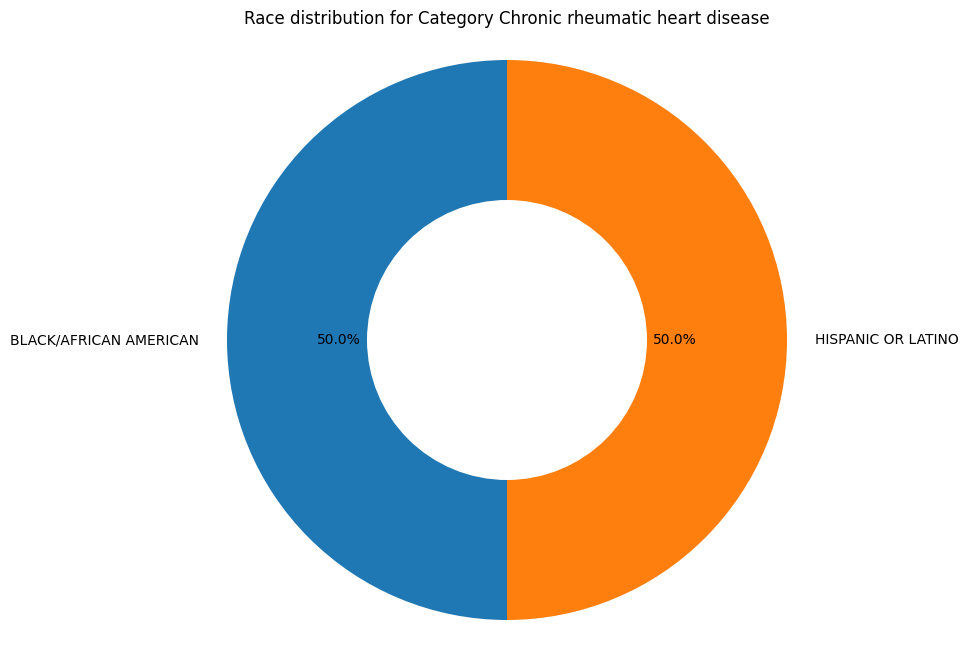

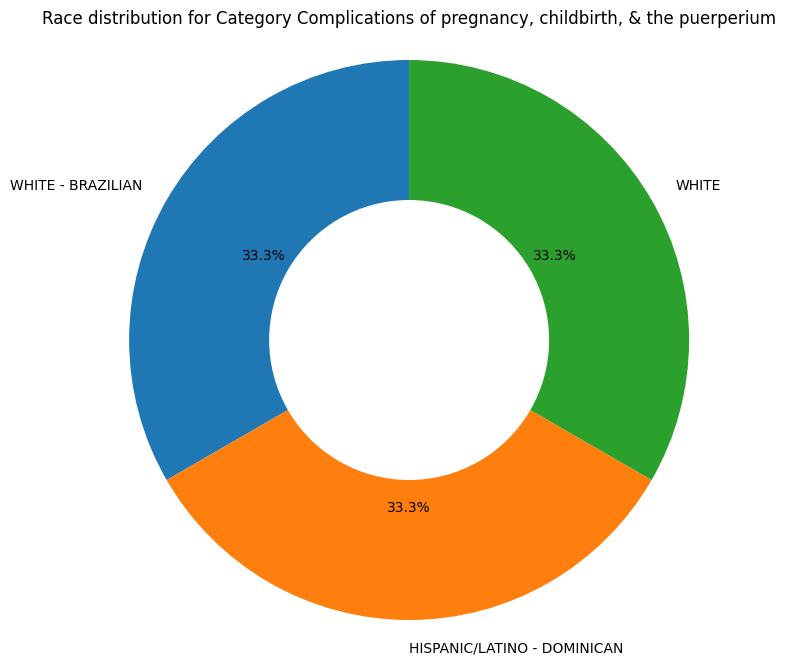

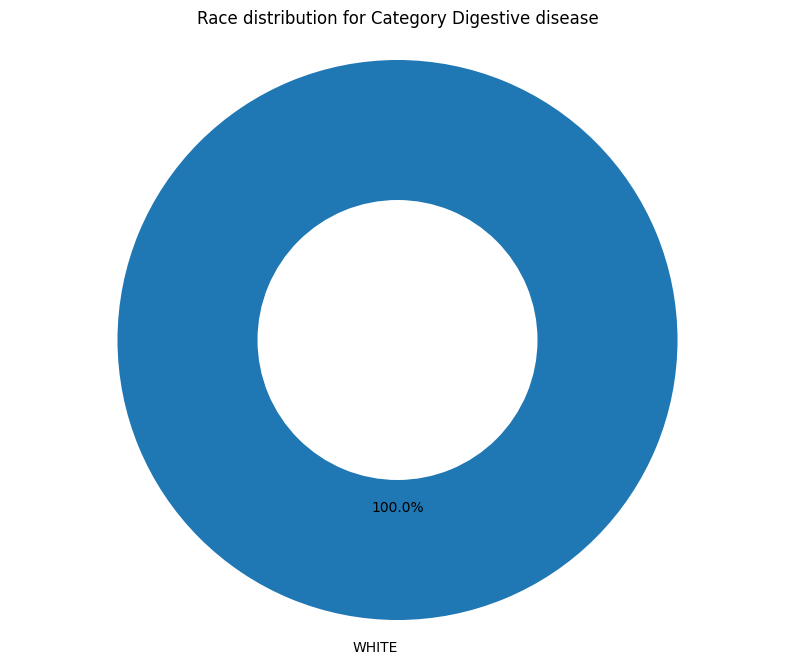

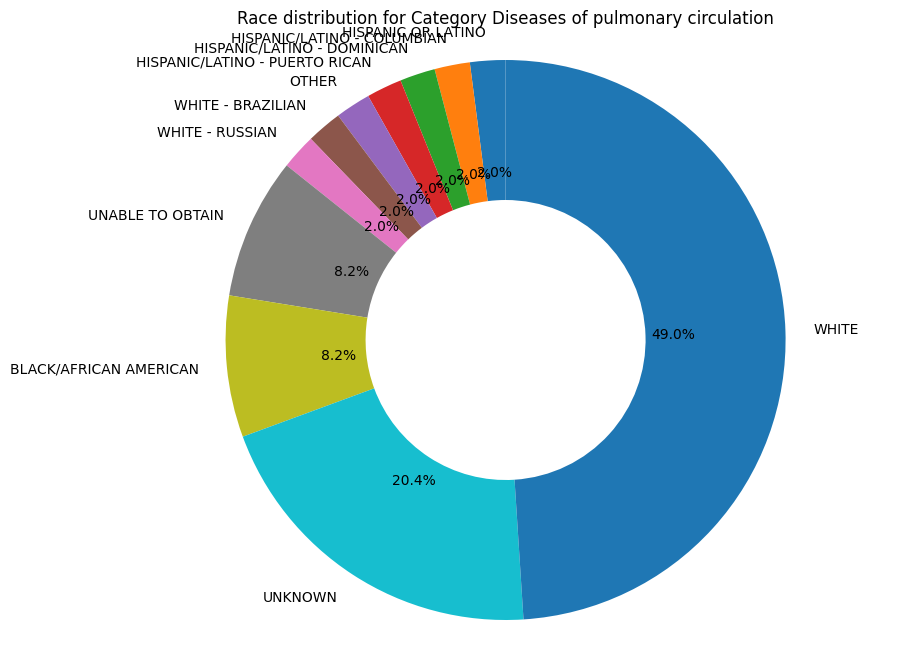

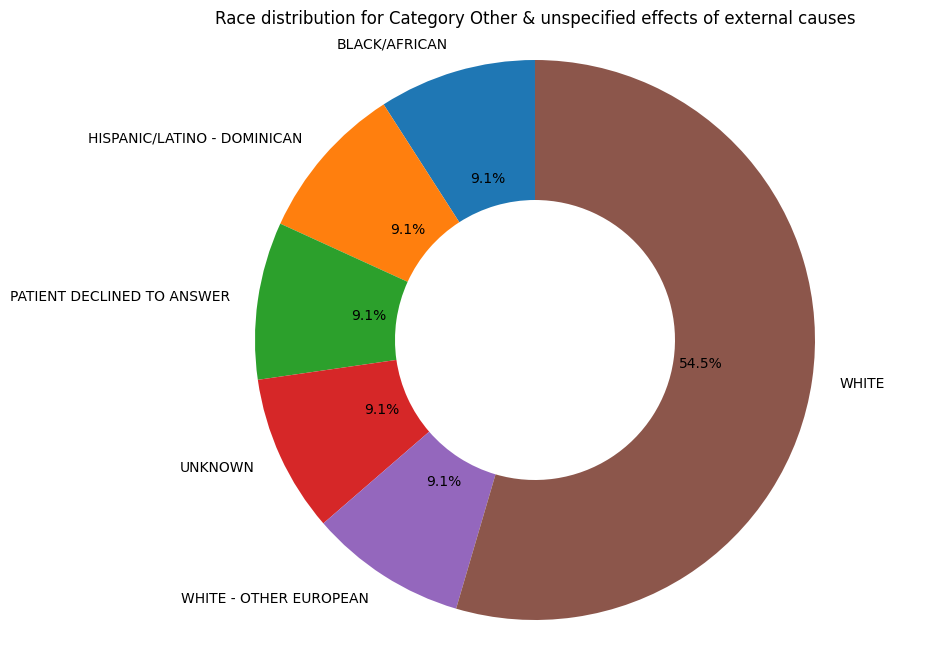

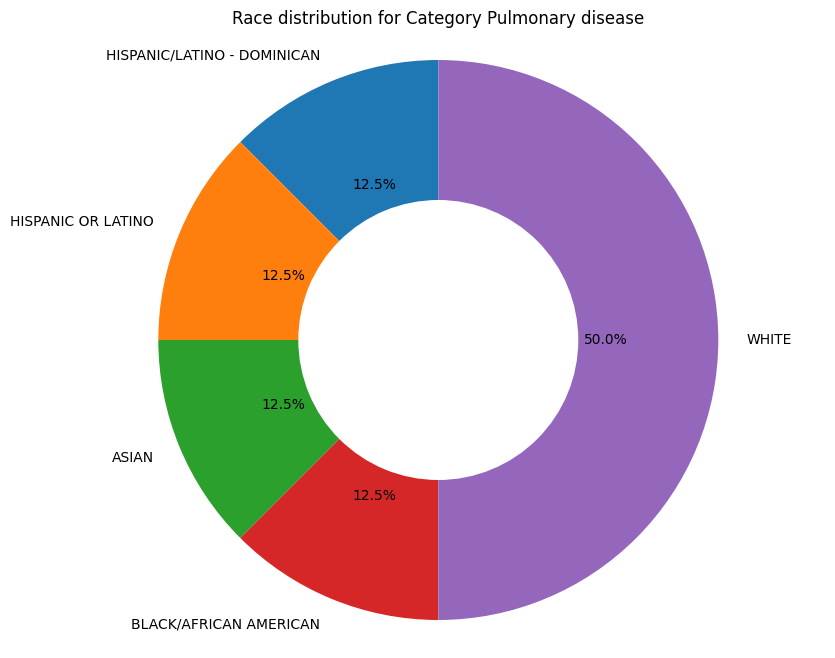

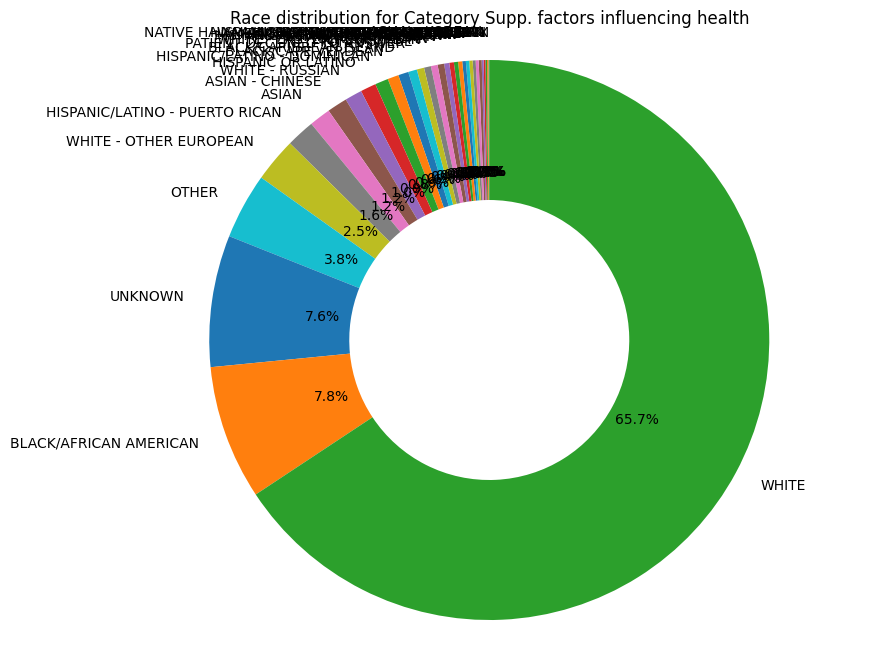

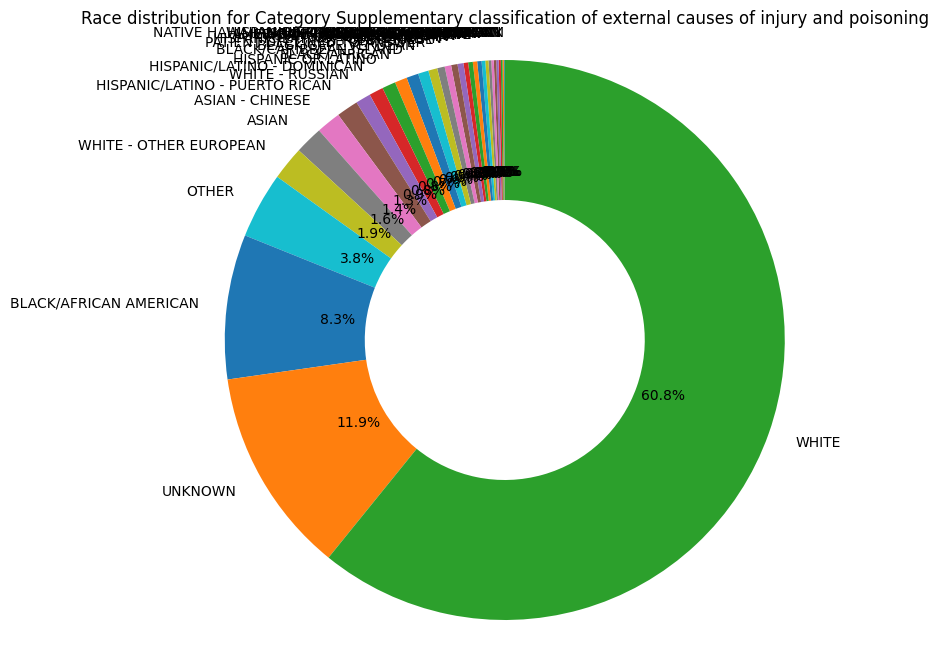

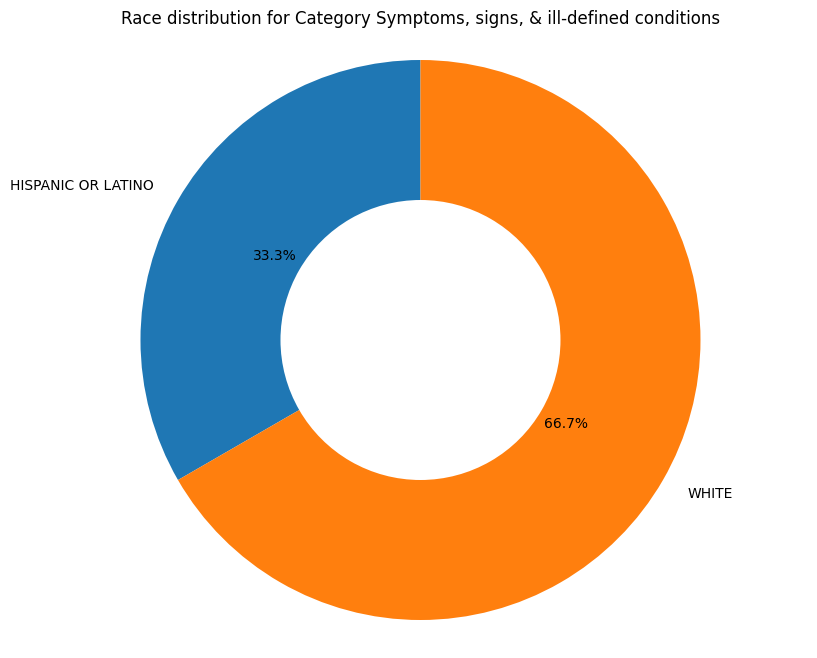

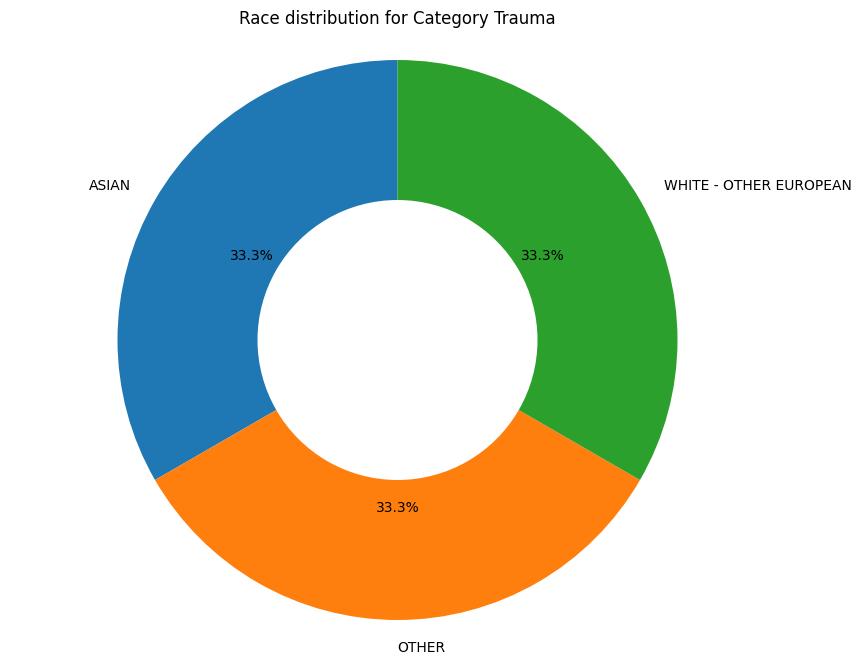

In [225]:
for category, group in all_e.groupby("category"):
    plt.figure(figsize = (10,8))

    # percents = sizes * 100 / sizes.sum()
    # plt.axis('equal')
    # labels = [f'{l}, {s:0.1f}%' for l, s in zip(labels, percents)]
    # plt.legend(bbox_to_anchor=(1, 1), loc='upper left', labels=labels)
    plt.pie(group['count'], labels=group['race'], autopct='%0.1f%%', startangle=90, wedgeprops=dict(width=0.5)) # type: ignore
    plt.title(f"Ehtnicity proportion in {category}")
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.savefig(POST_PROCESS_PATH + f"EDA_Eth_vs_Disease_{category}.jpg", bbox_inches = "tight")
    plt.show()

In [226]:
df33

,subject_id_x,hadm_id,admittime_x,gender,anchor_age,subject_id_y,seq_num,icd_code,icd_version,category,...,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,seasons
0,10001401,21544441,2131-06-04,F,89,10001401,6,890.0,10,Supplementary classification of external cause...,...,PHYSICIAN REFERRAL,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,WHITE,NaN,NaN,0,summer
1,10001919,29897682,2124-04-20,M,59,10001919,8,39.0,10,Supp. factors influencing health,...,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,OTHER,NaN,NaN,0,spring
2,10002266,24160398,2131-02-28,F,31,10002266,10,39.0,10,Supp. factors influencing health,...,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0,winter
3,10002348,22725460,2112-11-30,F,77,10002348,11,39.0,10,Supp. factors influencing health,...,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,WHITE,2112-11-30 15:08:00,2112-11-30 23:24:00,0,autumn
4,10002528,23193578,2168-12-11,F,26,10002528,7,869.0,10,Supplementary classification of external cause...,...,TRANSFER FROM HOSPITAL,REHAB,Other,ENGLISH,SINGLE,WHITE,2168-12-11 00:20:00,2168-12-11 06:18:00,0,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21354,19997538,22701415,2168-05-01,M,53,19997538,7,871.0,10,Supplementary classification of external cause...,...,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0,spring
21355,19997540,29178502,2154-03-03,M,30,19997540,2,915.0,9,Supplementary classification of external cause...,...,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2154-03-02 23:02:00,2154-03-03 02:45:00,0,spring
21356,19997843,20277361,2120-11-17,M,47,19997843,6,872.0,10,Supplementary classification of external cause...,...,CLINIC REFERRAL,SKILLED NURSING FACILITY,Other,?,NaN,UNKNOWN,2120-11-17 21:25:00,2120-11-18 02:39:00,0,autumn
21357,19997886,20793010,2186-11-12,M,67,19997886,2,43.0,10,Supp. factors influencing health,...,CLINIC REFERRAL,HOSPICE,Other,ENGLISH,WIDOWED,WHITE,2186-11-11 16:45:00,2186-11-12 08:27:00,0,autumn


In [227]:
df33.to_csv(POST_PROCESS_PATH + "summarized_icd_details_latest.csv", index = False)